# LSTM을 이용한 텍스트 생성
- 데이터 다운로드 : 캐글 New york times comments
- ArticlesApril

In [2]:
import numpy as np
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)
import pandas as pd
df = pd.read_csv("ArticlesApril2018.csv", encoding = 'latin1')
df.head(3)

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...


- 데이터 전처리 : headline column만 사용

In [3]:
df.headline.isna().sum()

0

In [4]:
headlines = df["headline"].values.tolist()

In [5]:
headlines[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [6]:
len(headlines)

1324

In [7]:
# 노이즈 데이터("Unknown") 제거
headlines = [line for line in headlines if line != "Unknown"]
len(headlines)

1214

In [8]:
# encoding, 구둣점 제거, 소문자로 변환
import re
def preprocessing(s):
    s = s.encode("utf8").decode('ascii', 'ignore')
    s = re.sub("[^A-Za-z0-9 ]","", s)
    return s.lower()

In [9]:
headlines = [preprocessing(line) for line in headlines ]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [11]:
# 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(headlines)

In [12]:
# 단어 집합 크기 - Keras Tokenizer의 시작 인덱스가 1이기 때문에 1을 더해주어야 함
vocab_size = len(t.word_index) + 1
vocab_size

3494

In [13]:
sequences = []
for line in headlines:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])
sequences[:10]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116]]

In [14]:
# sequence 중에서 제일 길이가 긴 것
max_len = max(len(seq) for seq in sequences)
max_len

24

In [15]:
# padding 주기
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre')
sequences[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115]], dtype=int32)

In [16]:
X = sequences[:, :-1]
y = sequences[:, -1]
Y = to_categorical(y)
X.shape, y.shape

((7803, 23), (7803,))

### 모델 정의/설정/학습
- Embedding vector 갯수 : 10
- LSTM unit 갯수 : 128

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU

In [18]:
# Embedding = 4, LSTM = 128
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim = 10, input_length = max_len-1),
    GRU(128), # activation = tanh 는 default 옵션
    Dense(vocab_size, activation = "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 gru (GRU)                   (None, 128)               53760     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 539,426
Trainable params: 539,426
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile("adam", "categorical_crossentropy", ["accuracy"] )

In [20]:
%time hist = model.fit(X, Y, epochs = 200, verbose = 0)

CPU times: user 4min 35s, sys: 30 s, total: 5min 5s
Wall time: 3min 51s


In [21]:
hist.history["accuracy"][-1]

0.9145200848579407

In [22]:
from my_util import sentence_generation

print(sentence_generation(model, t, max_len, "is", 8))
print(sentence_generation(model, t, max_len, "school", 8))
print(sentence_generation(model, t, max_len, "how", 8))
print(sentence_generation(model, t, max_len, "former", 8))

is it wrong to focus on animal welfare when
school a global populist tide a pope is remaking
how to make a crossword puzzle protest camp looks
former judge to review files seized in searches cheerleaders


- 훈련과정 시각화

In [ ]:
y_acc = hist.history["accuracy"]
y_loss = hist.history["loss"]
xs = np.arange(1, len(y_acc) + 1)

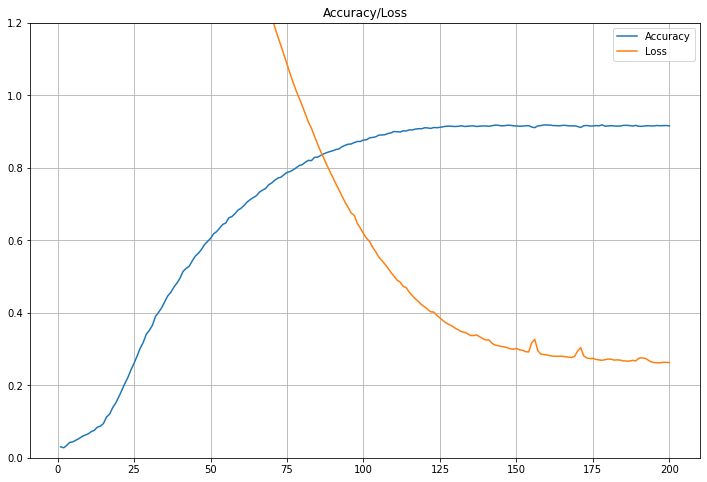

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label="Accuracy")
plt.plot(xs, y_loss, label="Loss")
plt.grid(),plt.legend(),plt.title("Accuracy/Loss")
plt.ylim(0,1.2)
plt.show()

SimpleRNN 으로 했을때


In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Embedding = 4, SimpleRNN = 32
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim = 10, input_length = max_len-1),
    SimpleRNN(32), # activation = tanh 는 default 옵션
    Dense(vocab_size, activation = "softmax")
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 10)            34940     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense_2 (Dense)             (None, 3494)              115302    
                                                                 
Total params: 151,618
Trainable params: 151,618
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile("adam", "categorical_crossentropy", ["accuracy"] )
%time hist = model2.fit(X, Y, epochs = 200, verbose = 0)

CPU times: user 26min 29s, sys: 3min 3s, total: 29min 32s
Wall time: 17min 7s


In [ ]:
hist.history["accuracy"][-1]

0.8717160224914551